In [14]:

# %pip install wordcloud
# %pip install praw

In [15]:
shoe_brand = ''

In [16]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [17]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
r = praw.Reddit(client_id='GJtzNYyCMIW-66t_xry24Q',
                     client_secret='ClyB_Id7qbhShlg4P43xqrLiyXPvyA',
                     user_agent='ljx597620034')

In [19]:
subreddit = r.subreddit(shoe_brand)

shoes_subreddit_top_posts = [*subreddit.top(limit=None)] # top posts all time

print(len(shoes_subreddit_top_posts))

1000


In [20]:
shoes0 = shoes_subreddit_top_posts[0]

# pprint(vars(news0)) 
print(shoes0.title) # headline
print(shoes0.score) # upvotes
print(shoes0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(shoes0.created)) # date and time
print(shoes0.num_comments) # no. of comments
print(shoes0.upvote_ratio) # upvote / total votes
print(shoes0.total_awards_received) # no. of awards given

PUMA x NINTENDO Future Rider NES™
122
1609407429.0
2020-12-31 04:37:09
5
1.0
0


In [21]:
title = [i.title for i in shoes_subreddit_top_posts]
shoes = pd.DataFrame({
    "title": title,
})
shoes.head()

,title
0,PUMA x NINTENDO Future Rider NES™
1,Bought my wife the new Pastels to rock with he...
2,Can someone help me I.D these? I can't find th...
3,New to Reddit. Wanted to Share my Happy Place 😃
4,My cat and my other cats


In [22]:
sid = SentimentIntensityAnalyzer()

In [23]:
res = [*shoes['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.8016, 'neg': 0.0, 'neu': 0.55, 'pos': 0.45}]


In [24]:
sentiment_df = pd.DataFrame.from_records(res)

shoes = pd.concat([shoes, sentiment_df], axis=1, join='inner')
shoes.head()

,title,neg,neu,pos,compound
0,PUMA x NINTENDO Future Rider NES™,0.0,1.000,0.000,0.0000
1,Bought my wife the new Pastels to rock with he...,0.0,1.000,0.000,0.0000
2,Can someone help me I.D these? I can't find th...,0.0,0.550,0.450,0.8016
3,New to Reddit. Wanted to Share my Happy Place 😃,0.0,0.543,0.457,0.7096
4,My cat and my other cats,0.0,1.000,0.000,0.0000


In [25]:
THRESHOLD = 0.4

conditions = [
    (shoes['compound'] <= -THRESHOLD),
    (shoes['compound'] > -THRESHOLD) & (shoes['compound'] < THRESHOLD),
    (shoes['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
shoes['label'] = np.select(conditions, values)

shoes.head()

,title,neg,neu,pos,compound,label
0,PUMA x NINTENDO Future Rider NES™,0.0,1.000,0.000,0.0000,neu
1,Bought my wife the new Pastels to rock with he...,0.0,1.000,0.000,0.0000,neu
2,Can someone help me I.D these? I can't find th...,0.0,0.550,0.450,0.8016,pos
3,New to Reddit. Wanted to Share my Happy Place 😃,0.0,0.543,0.457,0.7096,pos
4,My cat and my other cats,0.0,1.000,0.000,0.0000,neu


In [26]:
sentence0 = shoes.title.iloc[0]
print(sentence0)
words0 = shoes.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0: 
    if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
        pos_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
        neg_list.append(word)
    else:
        neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")

if score['compound'] >= THRESHOLD:
    print(f"The compound value : {score['compound']} >= {THRESHOLD}")
    print(f"\nThis sentence is positive")
elif score['compound'] <= -THRESHOLD:
    print(f"\nThis sentence is negative")
    print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
else:
    print(f"\nThis sentence is neutral")
    # print(f"The compound value : {-THRESHOLD}<={score['compound']<={THRESHOLD}}") # errors out when anything is 100% neutral

PUMA x NINTENDO Future Rider NES™
['PUMA', 'x', 'NINTENDO', 'Future', 'Rider', 'NES™']

Positive: []
Neutral: ['PUMA', 'x', 'NINTENDO', 'Future', 'Rider', 'NES™']
Negative: []

This sentence is 0.0% negative
This sentence is 100.0% neutral
This sentence is 0.0% positive

This sentence is neutral


In [27]:
shoes.label.value_counts()

neu    714
pos    255
neg     31
Name: label, dtype: int64

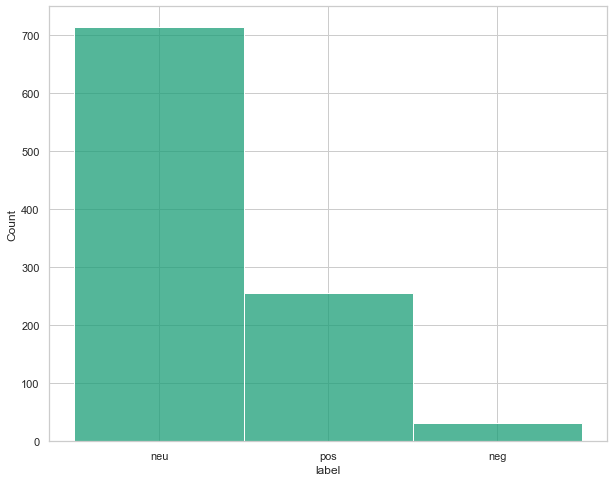

In [28]:
sns.histplot(shoes.label);

In [29]:
def shoes_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
shoes_sub = shoes.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
shoes_title_output(shoes_sub, "pos")

print("\nNeutral news")
shoes_title_output(shoes_sub, "neu")

print("\nNegative news")
shoes_title_output(shoes_sub, "neg")

Positive news
Puma did an amazing job with Dortmund's fourth kit.
How are people getting these laces? I’ve seen them on multiple pics but the laces on the website don’t look anything like this.
My sister wants to but these trainers but doesn't know what model they are. Some help would be appreciated
The most welcome FedEx delivery of the week
40% off puma website. Has some restrictions but hope someone enjoys it: TMT-SK3B6R5FWZ

Neutral news
History of PUMA
Can anyone tell me what Puma's these are?
Can anyone identify these canvas sneakers? There’s no name or identifying marks on them.
Should I?
I found these three at my local @footlocker for between $25-$29 each. And imagine, I almost went to work on my day off to catch up on paperwork.

Negative news
Haters will say it’s fake
Finally here!! They’re in better condition than I thought! Shame you can’t find these brand new no more :(
Bad boys puma… future rider icons, I had to bring it out 🔥
Bots and Scalpers Are More Ridiculous Than I 

In [30]:
stop_words = stopwords.words('english')
def custom_tokenize(text): 
  # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()

  # split on words only 
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')  
    tokens = tk.tokenize(text)
    

  # remove stop words
    words = [w for w in tokens if not w in stop_words] 
    return words

In [31]:
def tokens_2_words(df, label):
  # subset titles based on label
    titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(shoes, 'pos')
neg_words = tokens_2_words(shoes, 'neg')

In [32]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('puma', 75),
 ('help', 63),
 ('shoes', 40),
 ('love', 33),
 ('know', 31),
 ('find', 30),
 ('pair', 28),
 ('anyone', 28),
 ('please', 23),
 ('need', 19),
 ('new', 17),
 ('got', 17),
 ('would', 15),
 ('like', 15),
 ('pumas', 14),
 ('thanks', 13),
 ('one', 13),
 ('shoe', 13),
 ('first', 12),
 ('identify', 12)]

In [33]:
pos_im = [str(p) for p in pos_words] 
pos_str = ",".join(pos_im) 
neg_im = [str(p) for p in neg_words] 
neg_str = ",".join(neg_im)

<function matplotlib.pyplot.show(close=None, block=None)>

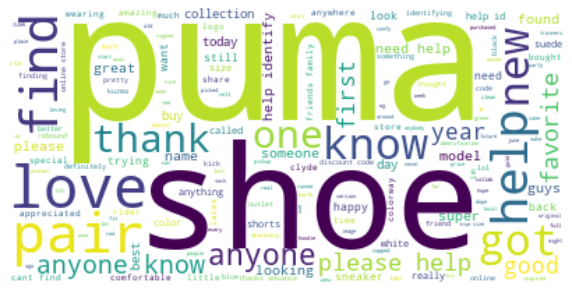

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_pos = WordCloud(background_color = "white").generate(pos_str)
word_cloud_neg = WordCloud().generate(neg_str)
plt.imshow(word_cloud_pos,interpolation = "bilinear") 
plt.axis("off") 
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

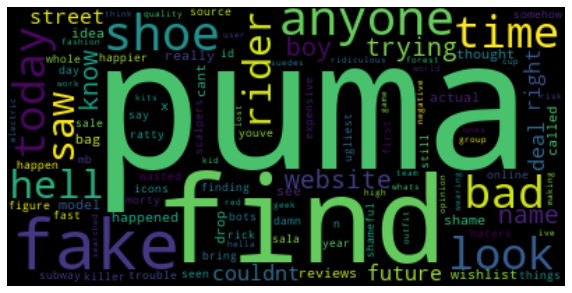

In [35]:
plt.imshow(word_cloud_neg,interpolation = "bilinear") 
plt.axis("off") 
plt.show